<a href="https://colab.research.google.com/github/barrytl/CE6003/blob/master/Example_3_2_HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histogram of Orientated Gradients (HOG) Feature Descriptor
In this example we will explore using the Histogram of Orientated Gradients feature descriptor for pedestrian detection. We will use the built-in [HOG descriptor](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) from the Scikit Image python package for visualisation of the HOG descriptor.  We will then use the OpenCV built-in [HOG descriptor](https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html) and pretrained SVM classifier to demonstrate full pedestrian detection at different scales in the test image.

![HoG Visualisation ](https://github.com/tonyscan6003/CE6003/blob/master/images/hog_image.jpg?raw=true
)
 


##**HouseKeeping**:
Import packages, define function to read image, read image

In [1]:
import numpy as np
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	return temp_image



Lets Load an image from the web with pedestrians. (You can modify this to your own image. Note that you can adjust the scale of your image using scale factor if it is too large and causes the pedestrian detector later on to run slowly)

In [2]:
# Set Image URL
test_image_url = "https://static01.nyt.com/images/2017/11/03/nyregion/00pedxing01/00pedxing01-superJumbo.jpg"
# Set Image Scale factor
scale_factor = 4


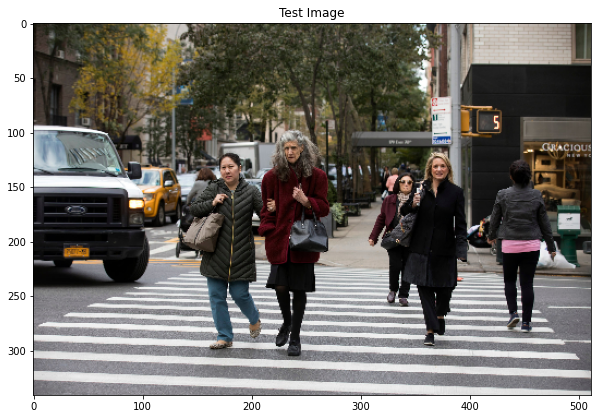

In [3]:
# Read image
test_image = url_to_image(test_image_url)

# Resize image if required.
test_size = np.shape(test_image)
test_image = cv2.resize(test_image, dsize=(int(test_size[1]/scale_factor),int(test_size[0]/scale_factor)), interpolation=cv2.INTER_CUBIC)

# Plot Test Image
plt.figure(figsize=(10,20))
plt.title('Test Image')
plt.imshow(test_image)


## HOG Descriptor Visualisation.
The HOG Descriptor is based on gradients at each point in the image (or detector window).
We will initially perform convolution of the input (greyscale) image with the simple x and y gradient filters, using the convolve2d command from scikit learn. We can plot these x,y gradients and obtain the magnitude and angle. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5, 1.0, 'Magnitide of gradient')

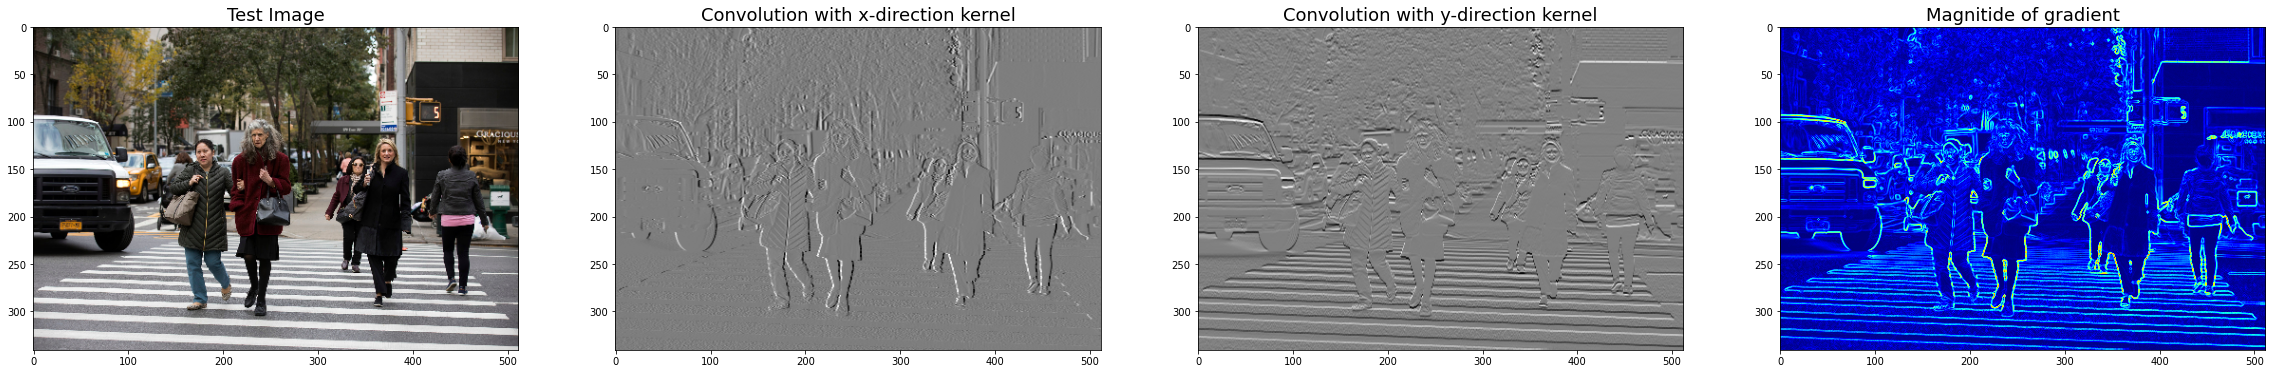

In [4]:

# Simple Gradient Filters
grad_x_filter = [[0,0,0],[-1,0,1],[0,0,0]]
grad_y_filter = [[0,-1,0],[0,0,0],[0,1,0]]

# Greyscale image
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Convolve kernel with image and get magnitude and angle.
conv_result_x = signal.convolve2d(gray, grad_x_filter, boundary='symm', mode='same')
conv_result_y = signal.convolve2d(gray, grad_y_filter, boundary='symm', mode='same')
conv_mag = np.sqrt(conv_result_x**2+conv_result_y**2)
conv_theta = np.arctan(conv_result_y/conv_result_x) 

# Create Plots
f, axarr = plt.subplots(1,4,figsize=(40,20))
axarr[0].imshow(test_image)
axarr[0].set_title('Test Image',fontsize =18)
axarr[1].imshow(conv_result_x,'gray')
axarr[1].set_title('Convolution with x-direction kernel',fontsize =18)
axarr[2].imshow((conv_result_y),'gray')
axarr[2].set_title('Convolution with y-direction kernel',fontsize =18)
axarr[3].imshow(conv_mag,'jet')
axarr[3].set_title('Magnitide of gradient',fontsize =18)

We will now obtain and display the HOG Descriptor using [feature.hog](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) from the Scikit Image (skimage) package.

It should be noted how the primary direction of the histograms aligns with the edges extracted with the gradient kernels.

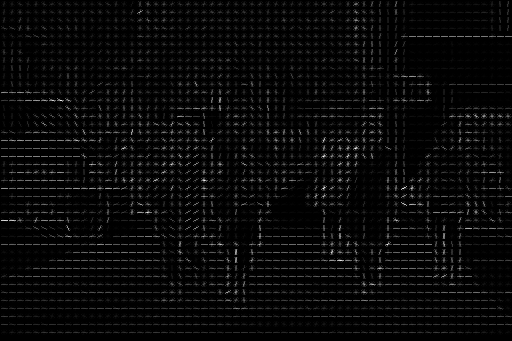

In [5]:
from skimage import feature
from skimage import exposure
from google.colab.patches import cv2_imshow

H,hogImage = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), 
                         transform_sqrt=True, block_norm="L1",visualize=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8") 
cv2_imshow(hogImage)

##Pedestrian Detection with HOG
In the code cells below we will use the [OpenCV HOG Descriptor](https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html) (HOGDescriptor) and pretrained SVM Classifier (hog.setSVMDectector) to perform pedestrian detection. The method (hog.detectMultiScale) will perform detection with a sliding window over an image pyramid, we can control the number steps the sliding window moves over the image (`win_stride`) and the degree of scaling in the pyramid (`pyramid_sf`)

You should adjust these parameters to see the effect of more/less levels in the pyramid and the spacing used for the sliding detector. In particular you may want to change these parameters to suit a different test image.  

In [6]:
# Set up Descriptor and SVM Classifier
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [7]:
win_stride = 4     # Sliding window stride
pyramid_sf = 1.2  # pyramid scaling factor

The method hog.detectMulitscale generates its own pyramid and we don't need to create one in advance. As a short aside we will visualise an Image pyramid (We can use some code from scikit Image to visulaise the [image pyramid](https://scikit-image.org/docs/dev/auto_examples/transform/plot_pyramid.html) for our image)

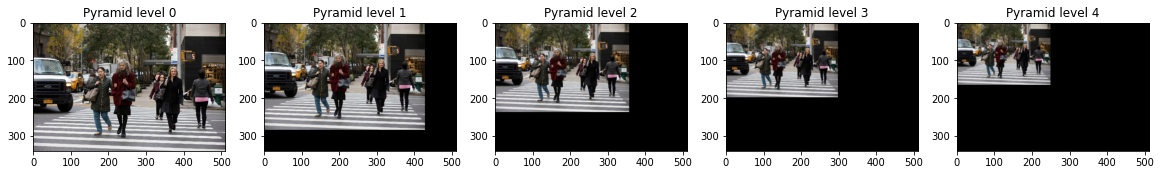

In [8]:
from skimage.transform import pyramid_gaussian

# image size
rows, cols, dim = test_image.shape

# Generate pyramid
pyramid = tuple(pyramid_gaussian(test_image, downscale=pyramid_sf, multichannel=True))

#plot first 5 levels of pyramid
f, axarr = plt.subplots(1,5,figsize=(20,40))
for i in range(5):
    p = pyramid[i]
    composite_image = np.zeros((rows, cols, 3), dtype=np.double)
    n_rows, n_cols = p.shape[:2]
    composite_image[0:n_rows, 0:n_cols] = p
    axarr[i].imshow(composite_image)
    axarr[i].title.set_text('Pyramid level '+str(i))

plt.show()

Run HOG detection over image pyramid

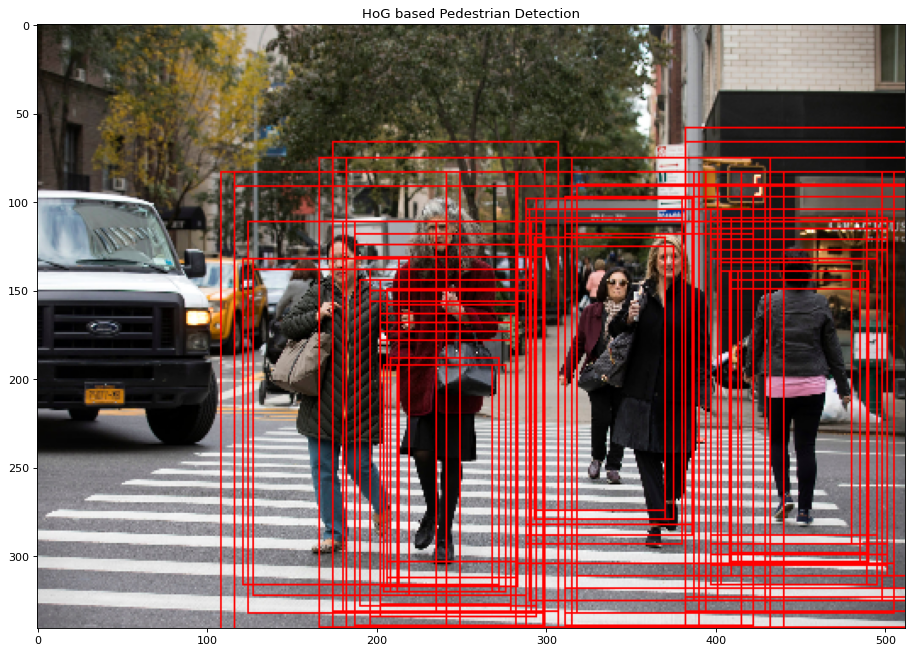

In [9]:

# run detection, using a spatial stride of 4 pixels (horizontal and verticle), a scale factor of 1.2,
(foundBoundingBoxes, weights) = hog.detectMultiScale(test_image, winStride=(win_stride, win_stride), 
                                                     padding=(2*win_stride, 2*win_stride), scale=pyramid_sf, finalThreshold=0)

# Draw bounding boxes around pedestrian detections.
redColor = (255, 0, 0)
lineThickness = 1
imgWithRawBboxes = test_image.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
        cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), redColor, lineThickness)

# Plot Image with bounding boxes shown.        
plt.figure(figsize=(14, 10), dpi=80)
plt.title('HoG based Pedestrian Detection')
plt.imshow(imgWithRawBboxes, aspect='auto') 
plt.show()

Finally we will obsevere the effect of applying Non-Maximum Suppression to remove excess detections.

Before suppression, we had 103 bounding boxes, after suppression we have 5


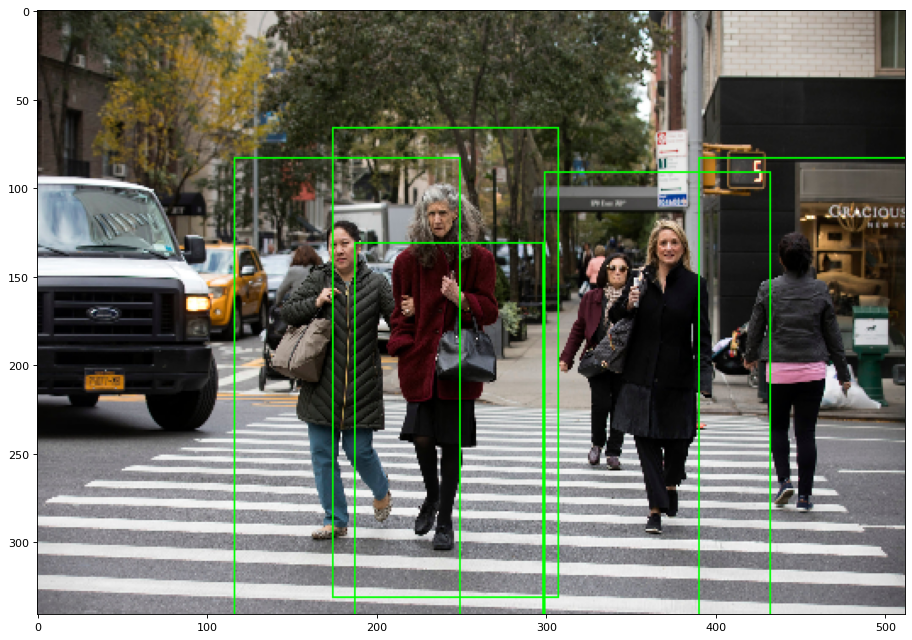

In [10]:
from imutils.object_detection import non_max_suppression

# convert our bounding boxes from format (x1, y1, w, h) to (x1, y1, x2, y2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in foundBoundingBoxes])

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(rects, probs=None, overlapThresh=0.65)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(rects), len(nmsBoundingBoxes)))

greenColor = (0, 255, 0)
lineThickness = 1
# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(test_image, (xA, yA), (xB, yB), greenColor, lineThickness)

# Plot figures
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(test_image, aspect='auto') 
plt.show()